# Exogenous Variables (30-day Resample): Time Series Analysis

If we decide to use exogenous variables to fit our model and predict ADP in the future, we will need to predict the values of these variables in order have inputs for our predictive model. Therefore, we need to analyze the trends of the exogenous variables so we can determine how to predict the twelve future values.

Our exogenous variables are:

* admission and discharge counts

* average length of stay

* felony crime counts

* felony arrest counts

These datasets seem to be about a month behind the DOC Daily Inmates in Custody dataset. Thus, we will need to adjust for any missing data *AND* use an ARIMA model to extend our 30-day periods to be compatible with our ADP data and the DOC exogenous variables.

This notebook will analyze the trends in the 30 day time series signals collected in `01_get_data.ipynb`. This notebook will also be using the variables above in such a way that aligns with the criminal legal system workflow. The criminal-legal system has a well defined procedure. Someone commits a crime and is then arrested, arraigned and proscecuted in the court, and depending on judicial discretion, and bail reform laws, is either detained or not in DOC custody. Therefore, the crime, arrest, and DOC variables have a relationship with one another in this respective order and we will use crime to predict arrests, which will then predict DOC variables, which will then predict ADP (aka the funnel method).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.api import SARIMAX
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from functions import *
%matplotlib inline

## Step 1: Import Data

This data was saved in `01_get_data.ipynb`

In [2]:
_30day_pop_tot = pd.read_csv("../Data/_30_day_adp.csv", index_col = 0)
#specify data types for start and end date
_30day_pop_tot['Start Date'] = _30day_pop_tot['Start Date'].astype('datetime64[ns]')
_30day_pop_tot['End Date'] = _30day_pop_tot['End Date'].astype('datetime64[ns]')

_30day_pop_tot.head()

,Start Date,End Date,ADP
0,2016-05-30,2016-06-28,9813.0
1,2016-06-29,2016-07-28,9748.0
2,2016-07-29,2016-08-27,9767.0
3,2016-08-28,2016-09-26,9882.0
4,2016-09-27,2016-10-26,9810.0


In [3]:
#look at the last 30-day period
_30day_pop_tot.tail(1)

,Start Date,End Date,ADP
97,2024-05-18,2024-06-16,6341.0


In [4]:
joined_doc_ivs_df = pd.read_csv("../Data/_30_day_IVs.csv", index_col = 0)
#specify data types for start and end date
joined_doc_ivs_df['Start Date'] = joined_doc_ivs_df['Start Date'].astype('datetime64[ns]')
joined_doc_ivs_df['End Date'] = joined_doc_ivs_df['End Date'].astype('datetime64[ns]')
joined_doc_ivs_df.head()

,Start Date,End Date,admission_count,discharge_count,Avg LOS Days
0,2016-05-30,2016-06-28,4825,4851,61.091824
1,2016-06-29,2016-07-28,4774,4847,61.526544
2,2016-07-29,2016-08-27,4783,4640,59.230968
3,2016-08-28,2016-09-26,4672,4617,57.644910
4,2016-09-27,2016-10-26,4619,4694,63.246173


In [5]:
#look at the last 30-day period
joined_doc_ivs_df.tail(1)

,Start Date,End Date,admission_count,discharge_count,Avg LOS Days
96,2024-04-18,2024-05-17,1982,2052,105.554798


In [6]:
crime_data = pd.read_csv("../Data/_30_day_crime_counts.csv", index_col = 0)
#specify data types for start and end date
crime_data['Start Date'] = crime_data['Start Date'].astype('datetime64[ns]')
crime_data['End Date'] = crime_data['End Date'].astype('datetime64[ns]')

#get arrest data
arrest_data = pd.read_csv("../Data/_30_day_arrest_counts.csv", index_col = 0)
#specify data types for start and end date
arrest_data['Start Date'] = arrest_data['Start Date'].astype('datetime64[ns]')
arrest_data['End Date'] = arrest_data['End Date'].astype('datetime64[ns]')


In [7]:
crime_data.head()

,Start Date,End Date,total_felony_crimes,murder_homicide_count,robbery_count,assault_count,burglary_count,rape_count,grand_larceny_count,grand_larceny_vehicle_count,weapons_count
0,2016-05-30,2016-06-28,12730,33,1272,1865,1094,154,3777,577,438
1,2016-06-29,2016-07-28,13042,40,1342,2070,1095,150,3834,592,399
2,2016-07-29,2016-08-27,13173,34,1379,1997,1123,137,3785,652,446
3,2016-08-28,2016-09-26,12678,34,1326,1875,1063,114,3711,605,468
4,2016-09-27,2016-10-26,12661,30,1309,1625,1120,122,3783,549,504


In [8]:
arrest_data.head()

,Start Date,End Date,total_felony_arrest,arrest_murder_homicide_count,arrest_robbery_count,arrest_assault_count,arrest_burglary_count,arrest_rape_count,arrest_grand_larceny_count,arrest_grand_larceny_vehicle_count,arrest_weapons_count
0,2016-05-30,2016-06-28,7630,86,809,1320,331,81,779,93,570
1,2016-06-29,2016-07-28,7866,82,819,1479,364,70,879,96,557
2,2016-07-29,2016-08-27,7918,110,872,1402,396,79,841,105,554
3,2016-08-28,2016-09-26,7505,77,820,1225,413,58,753,109,617
4,2016-09-27,2016-10-26,8091,75,892,1216,424,67,855,94,617


In [9]:
print(crime_data.tail(1)[['Start Date', 'End Date']])
print(arrest_data.tail(1)[['Start Date', 'End Date']])

   Start Date   End Date
94 2024-02-18 2024-03-18
   Start Date   End Date
94 2024-02-18 2024-03-18


In [10]:
print(len(crime_data),len(arrest_data),len(joined_doc_ivs_df),len(_30day_pop_tot))

95 95 97 98


As described above, the arrest and crime data are 1-2 data point behind the DOC data sets which is 1 data point behind the ADP dataset. We will need to find the best way to account for this missing data point. Since we are going to analyze the trends of each exogenous variable and use an ARIMA model to predict 12 future time periods, we might as well use the ARIMA model to predict the missing data point.

In [11]:
# Combine the dataframes into one big dataframe
exog_combined = pd.concat([joined_doc_ivs_df, crime_data[crime_data.columns.to_list()[2:]], arrest_data[arrest_data.columns.to_list()[2:]]], axis=1)
exog_combined.head()

,Start Date,End Date,admission_count,discharge_count,Avg LOS Days,total_felony_crimes,murder_homicide_count,robbery_count,assault_count,burglary_count,...,weapons_count,total_felony_arrest,arrest_murder_homicide_count,arrest_robbery_count,arrest_assault_count,arrest_burglary_count,arrest_rape_count,arrest_grand_larceny_count,arrest_grand_larceny_vehicle_count,arrest_weapons_count
0,2016-05-30,2016-06-28,4825,4851,61.091824,12730.0,33.0,1272.0,1865.0,1094.0,...,438.0,7630.0,86.0,809.0,1320.0,331.0,81.0,779.0,93.0,570.0
1,2016-06-29,2016-07-28,4774,4847,61.526544,13042.0,40.0,1342.0,2070.0,1095.0,...,399.0,7866.0,82.0,819.0,1479.0,364.0,70.0,879.0,96.0,557.0
2,2016-07-29,2016-08-27,4783,4640,59.230968,13173.0,34.0,1379.0,1997.0,1123.0,...,446.0,7918.0,110.0,872.0,1402.0,396.0,79.0,841.0,105.0,554.0
3,2016-08-28,2016-09-26,4672,4617,57.644910,12678.0,34.0,1326.0,1875.0,1063.0,...,468.0,7505.0,77.0,820.0,1225.0,413.0,58.0,753.0,109.0,617.0
4,2016-09-27,2016-10-26,4619,4694,63.246173,12661.0,30.0,1309.0,1625.0,1120.0,...,504.0,8091.0,75.0,892.0,1216.0,424.0,67.0,855.0,94.0,617.0


In [12]:
exog_combined.tail(3)

,Start Date,End Date,admission_count,discharge_count,Avg LOS Days,total_felony_crimes,murder_homicide_count,robbery_count,assault_count,burglary_count,...,weapons_count,total_felony_arrest,arrest_murder_homicide_count,arrest_robbery_count,arrest_assault_count,arrest_burglary_count,arrest_rape_count,arrest_grand_larceny_count,arrest_grand_larceny_vehicle_count,arrest_weapons_count
94,2024-02-18,2024-03-18,1961,1820,100.065898,13481.0,23.0,1232.0,2116.0,1022.0,...,460.0,8837.0,130.0,923.0,1806.0,583.0,62.0,987.0,173.0,562.0
95,2024-03-19,2024-04-17,1962,1946,97.841294,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,2024-04-18,2024-05-17,1982,2052,105.554798,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plot Exogenous Variables to help visualize trends over time

In [13]:
import matplotlib.gridspec as gridspec

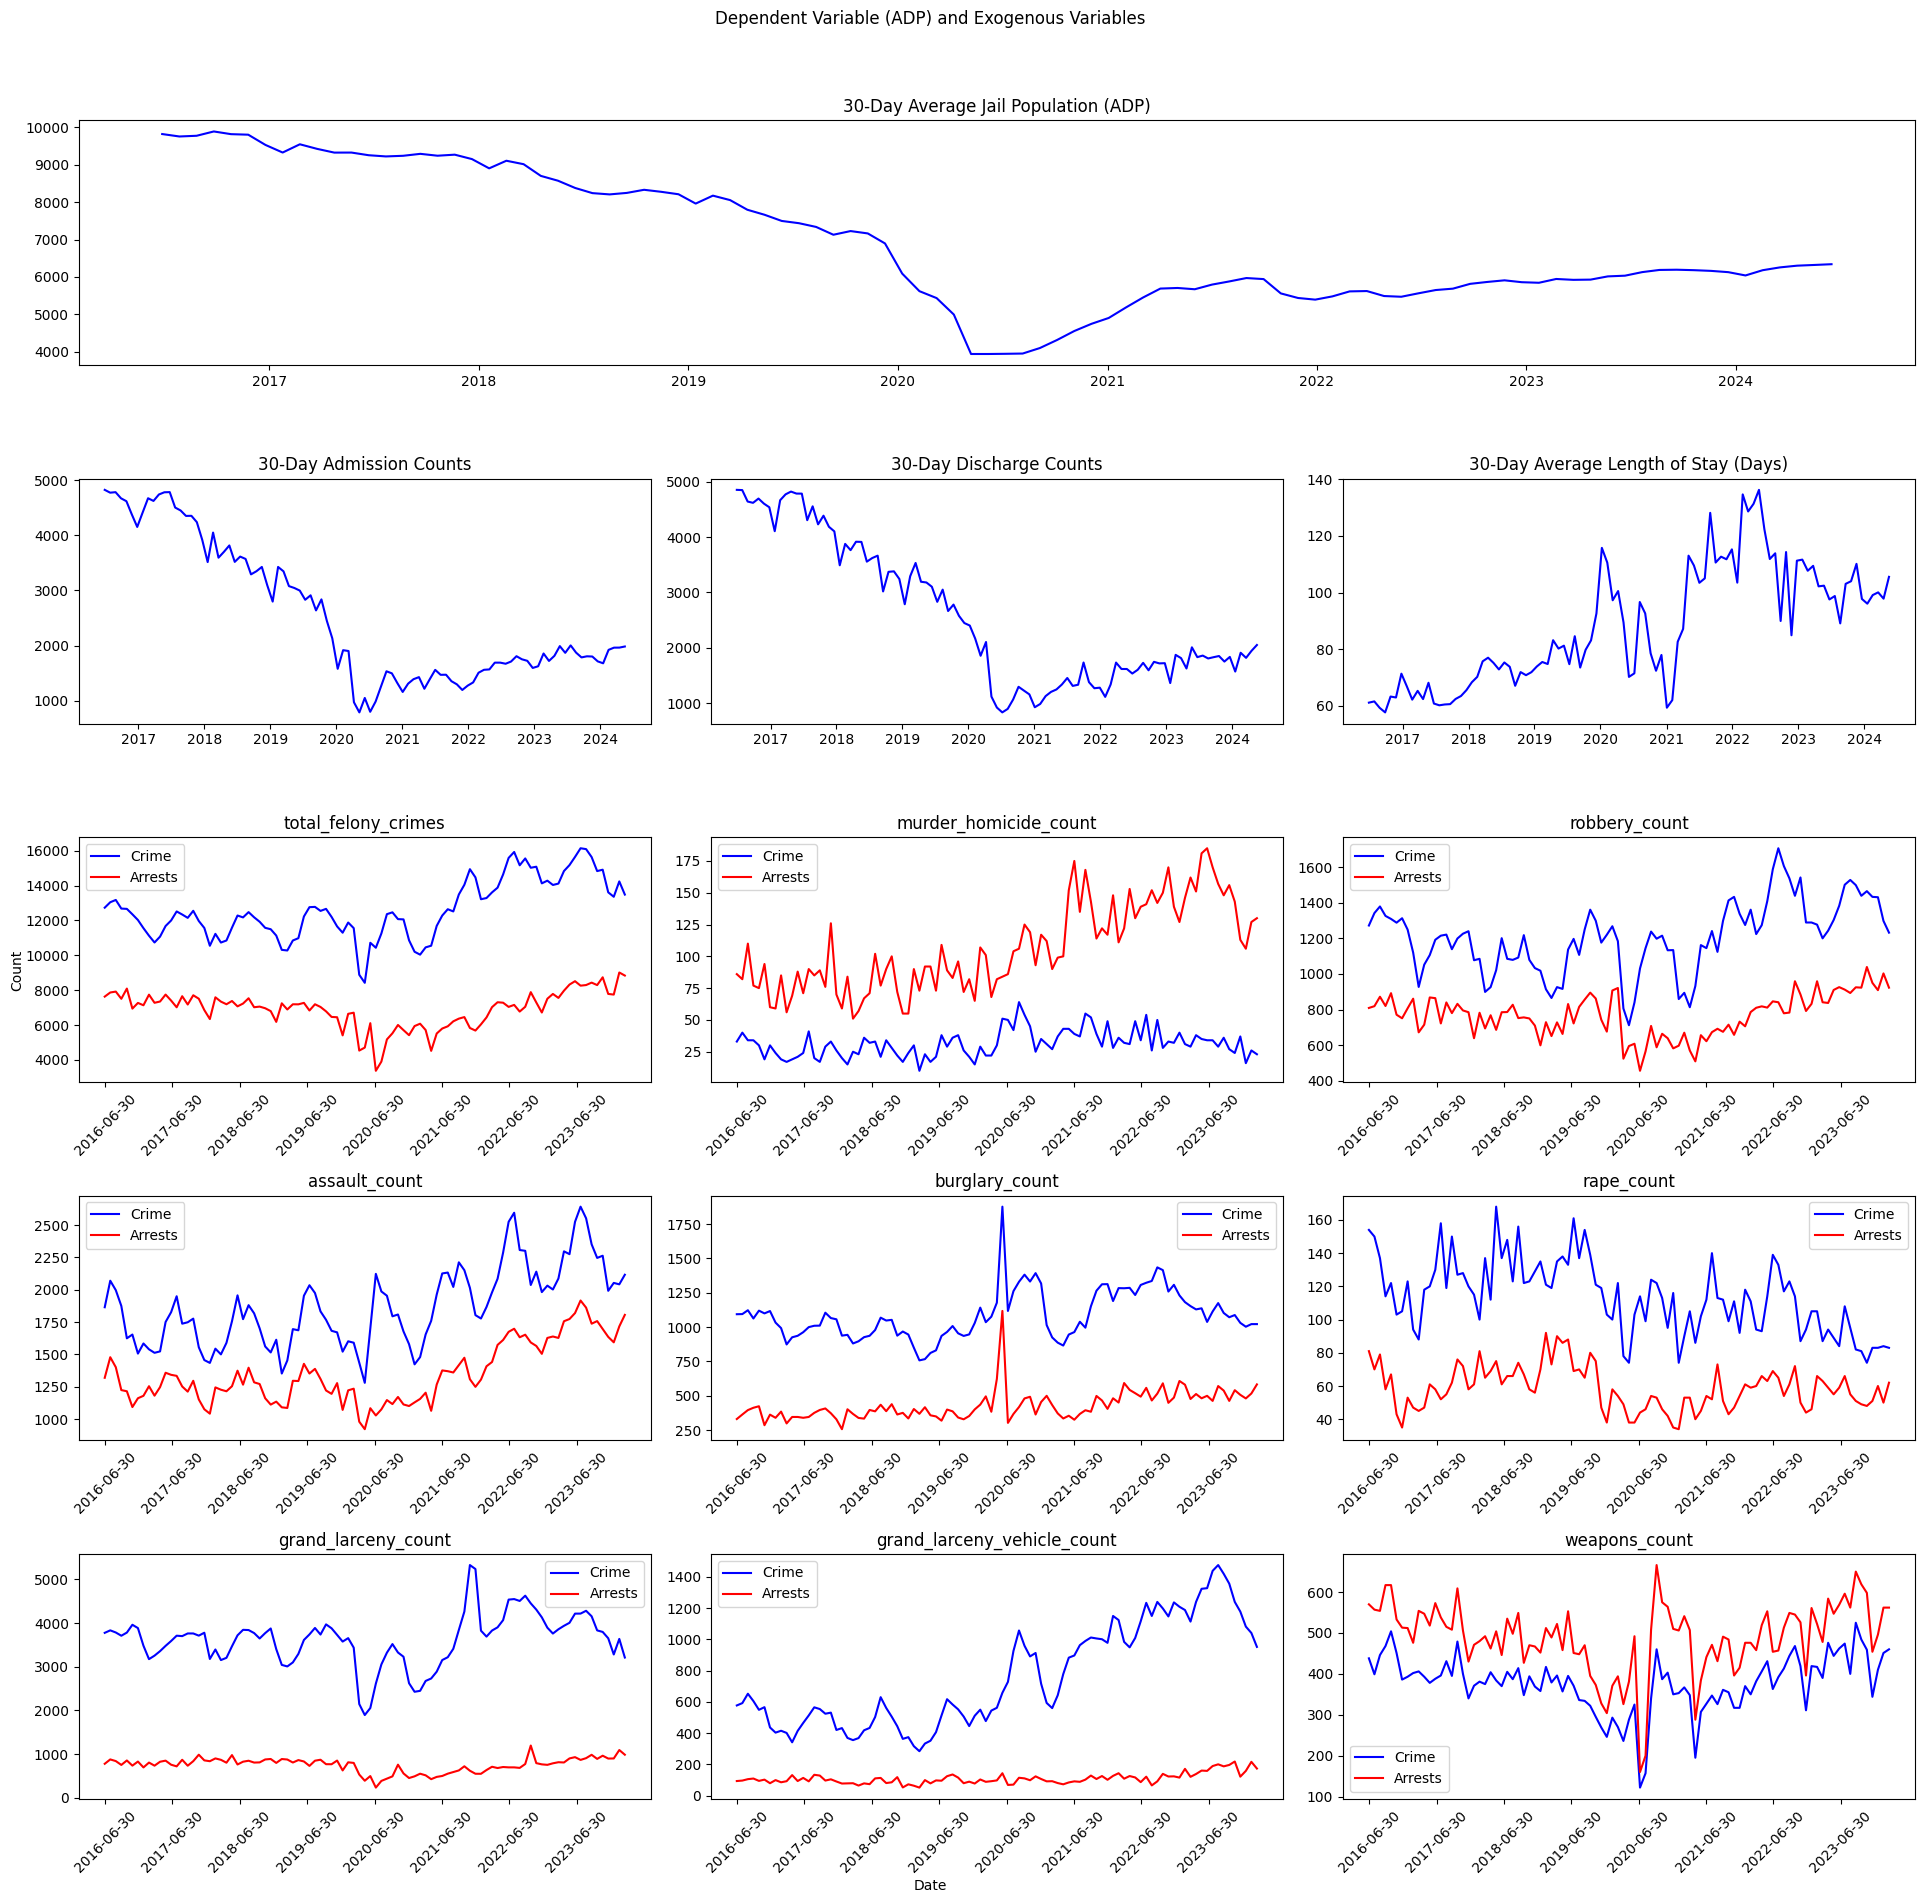

In [14]:
# Create a figure with a GridSpec layout
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(5, 3, figure=fig)

# ADP vs End Date (spanning all three columns in the first row)
ax0 = fig.add_subplot(gs[0, :])
ax0.plot(_30day_pop_tot['End Date'], _30day_pop_tot['ADP'], 'b', label='ADP')
ax0.set_title('30-Day Average Jail Population (ADP)')

# admission_count, discharge_count, los_days vs End Date in the second row
ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(joined_doc_ivs_df['End Date'], joined_doc_ivs_df['admission_count'], 'b', label='Admission Count')
ax1.set_title('30-Day Admission Counts')

ax2 = fig.add_subplot(gs[1, 1])
ax2.plot(joined_doc_ivs_df['End Date'], joined_doc_ivs_df['discharge_count'], 'b', label='Discharge Count')
ax2.set_title('30-Day Discharge Counts')

ax3 = fig.add_subplot(gs[1, 2])
ax3.plot(joined_doc_ivs_df['End Date'], joined_doc_ivs_df['Avg LOS Days'], 'b', label='LOS Days')
ax3.set_title('30-Day Average Length of Stay (Days)')


# Plot each column in crime_data vs End Date in the remaining subplots
for i, column in enumerate(crime_data.columns[2:]):
    ax = fig.add_subplot(gs[2 + i // 3, i % 3])
    ax.plot(crime_data['End Date'], crime_data[column], 'b', label='Crime')
    if i == 0:
        ax.plot(arrest_data['End Date'], arrest_data['total_felony_arrest'], 'r', label='Arrests')
    else:
        ax.plot(arrest_data['End Date'], arrest_data['arrest_' + column], 'r', label='Arrests')
    ax.set_title(column)
    ax.set_xticks(pd.date_range(start=crime_data['End Date'].min(), end=crime_data['End Date'].max(), freq='12M'))
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

# Set a common xlabel and ylabel
fig.text(0.5, 0.04, 'Date', ha='center')
fig.text(0.04, 0.5, 'Count', va='center', rotation='vertical')

fig.suptitle('Dependent Variable (ADP) and Exogenous Variables')

plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.savefig('../Outputs/30_day_dv_exog_plots.png', bbox_inches='tight')
plt.show()

## Step 2: Time Series Decomposition and Stationality

Decompose the signals into trend, seasonality, and residuals. These signals are all aggregated to 30-days (monthly), thus the period will by 12.

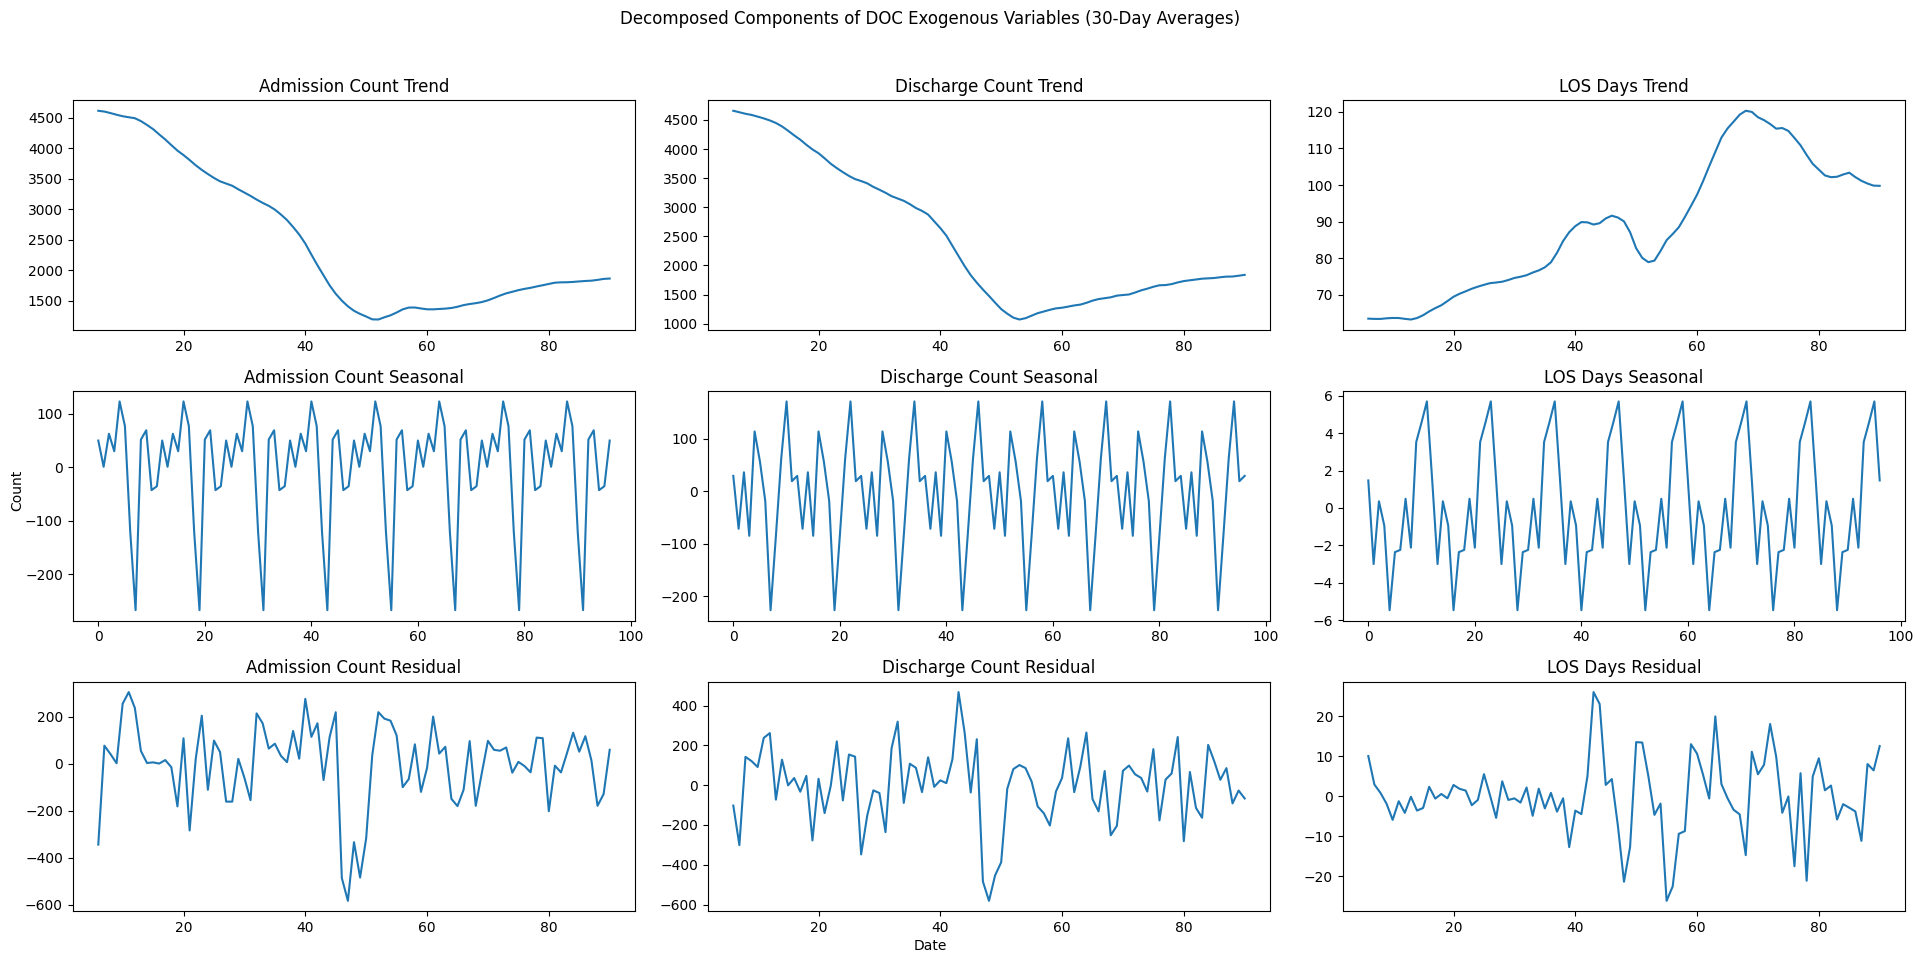

In [15]:
# Decompose the signals
admission_decomposition = seasonal_decompose(joined_doc_ivs_df['admission_count'], model='additive', period=12)
discharge_decomposition = seasonal_decompose(joined_doc_ivs_df['discharge_count'], model='additive', period=12)
los_days_decomposition = seasonal_decompose(joined_doc_ivs_df['Avg LOS Days'], model='additive', period=12)

# Create a figure with a GridSpec layout
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(3, 3, figure=fig)

# Define components and titles
components = ['trend', 'seasonal', 'resid']
titles = ['Trend', 'Seasonal', 'Residual']

# Plot the decomposed components for admission_count, discharge_count, and los_days
decompositions = [admission_decomposition, discharge_decomposition, los_days_decomposition]
decomposition_titles = ['Admission Count', 'Discharge Count', 'LOS Days']

for i, decomposition in enumerate(decompositions):
    for j, component in enumerate(components):
        ax = fig.add_subplot(gs[j, i % 3])
        ax.plot(decomposition.trend.index, getattr(decomposition, component), label=f'{decomposition_titles[i]} {titles[j]}')
        ax.set_title(f'{decomposition_titles[i]} {titles[j]}')

# Set a common xlabel and ylabel
fig.text(0.5, 0.04, 'Date', ha='center')
fig.text(0.04, 0.5, 'Count', va='center', rotation='vertical')

# Add a legend and title
fig.suptitle('Decomposed Components of DOC Exogenous Variables (30-Day Averages)')

plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.savefig('../Outputs/doc_exog_decomposed_components_plots_30days.png', bbox_inches='tight')
plt.show()

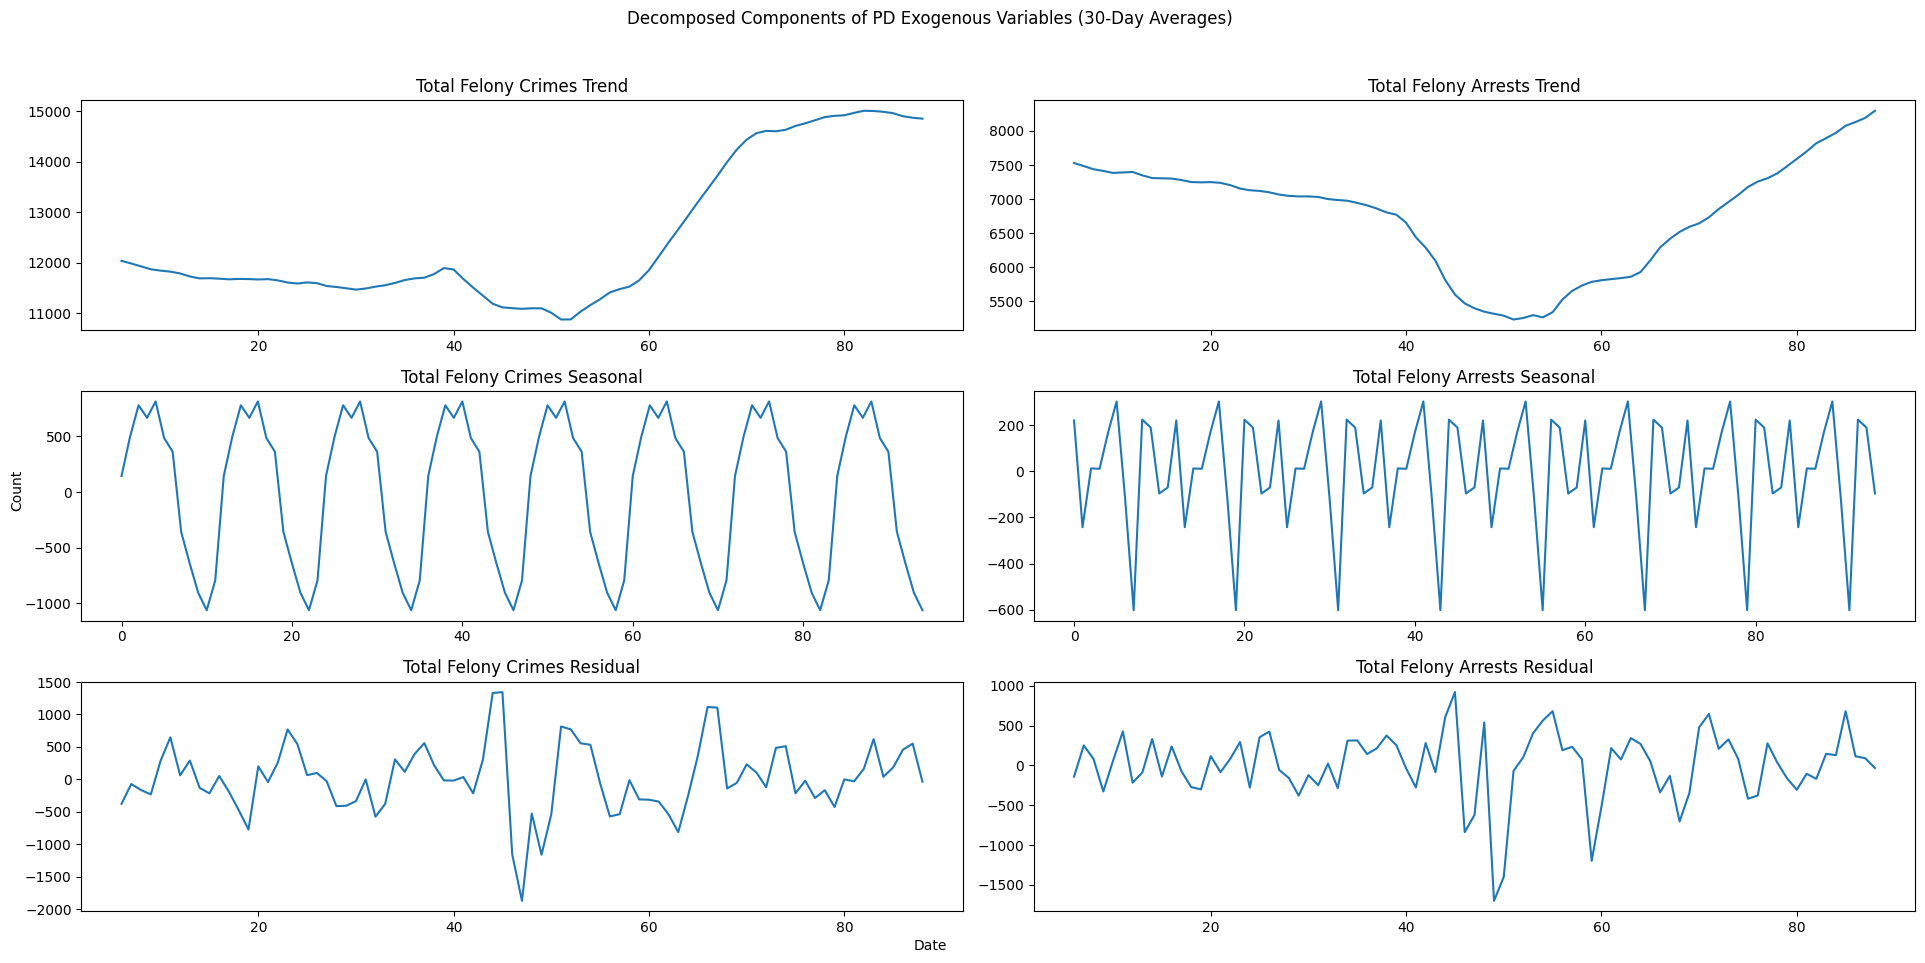

In [16]:
#Repeat for crime and arrests
# Decompose the signals
felony_crimes_decomposition = seasonal_decompose(crime_data['total_felony_crimes'].dropna(), model='additive', period=12)
felony_arrest_decomposition = seasonal_decompose(arrest_data['total_felony_arrest'].dropna(), model='additive', period=12)

# Create a figure with a GridSpec layout
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(3, 2, figure=fig)

# Define components and titles
components = ['trend', 'seasonal', 'resid']
titles = ['Trend', 'Seasonal', 'Residual']

# Plot the decomposed components for admission_count, discharge_count, and los_days
decompositions = [felony_crimes_decomposition, felony_arrest_decomposition]
decomposition_titles = ['Total Felony Crimes', 'Total Felony Arrests']

for i, decomposition in enumerate(decompositions):
    for j, component in enumerate(components):
        ax = fig.add_subplot(gs[j, i % 3])
        ax.plot(decomposition.trend.index, getattr(decomposition, component), label=f'{decomposition_titles[i]} {titles[j]}')
        ax.set_title(f'{decomposition_titles[i]} {titles[j]}')

# Set a common xlabel and ylabel
fig.text(0.5, 0.04, 'Date', ha='center')
fig.text(0.04, 0.5, 'Count', va='center', rotation='vertical')

# Add a legend and title
fig.suptitle('Decomposed Components of PD Exogenous Variables (30-Day Averages)')

plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.savefig('../Outputs/pd_exog_decomposed_components_plots_30days.png', bbox_inches='tight')
plt.show()

Determine stationality of signal

In [17]:
from pmdarima.arima.utils import ndiffs

In [18]:
for col in joined_doc_ivs_df.columns[2:]:
    print(f'The optimal d coefficient for {col} signal with alpha = 0.05 is: ', ndiffs(np.log(joined_doc_ivs_df[col]), test='adf'))
    print(f'The optimal d coefficient for {col} signal with alpha = 0.025 is: ', ndiffs(np.log(joined_doc_ivs_df[col]), test='adf', alpha = 0.025))

The optimal d coefficient for admission_count signal with alpha = 0.05 is:  1
The optimal d coefficient for admission_count signal with alpha = 0.025 is:  1
The optimal d coefficient for discharge_count signal with alpha = 0.05 is:  1
The optimal d coefficient for discharge_count signal with alpha = 0.025 is:  1
The optimal d coefficient for Avg LOS Days signal with alpha = 0.05 is:  1
The optimal d coefficient for Avg LOS Days signal with alpha = 0.025 is:  1


In [19]:
for col in crime_data.columns[2:]:
    print(f'The optimal d coefficient for {col} signal with alpha = 0.05 is: ', ndiffs(np.log(crime_data[col].dropna()), test='adf'))
    print(f'The optimal d coefficient for {col} signal with alpha = 0.025 is: ', ndiffs(np.log(crime_data[col].dropna()), test='adf', alpha = 0.025))
    print()

The optimal d coefficient for total_felony_crimes signal with alpha = 0.05 is:  1
The optimal d coefficient for total_felony_crimes signal with alpha = 0.025 is:  1

The optimal d coefficient for murder_homicide_count signal with alpha = 0.05 is:  1
The optimal d coefficient for murder_homicide_count signal with alpha = 0.025 is:  1

The optimal d coefficient for robbery_count signal with alpha = 0.05 is:  0
The optimal d coefficient for robbery_count signal with alpha = 0.025 is:  0

The optimal d coefficient for assault_count signal with alpha = 0.05 is:  0
The optimal d coefficient for assault_count signal with alpha = 0.025 is:  0

The optimal d coefficient for burglary_count signal with alpha = 0.05 is:  1
The optimal d coefficient for burglary_count signal with alpha = 0.025 is:  1

The optimal d coefficient for rape_count signal with alpha = 0.05 is:  0
The optimal d coefficient for rape_count signal with alpha = 0.025 is:  0

The optimal d coefficient for grand_larceny_count si

In [20]:
for col in arrest_data.columns[2:]:
    print(f'The optimal d coefficient for {col} signal with alpha = 0.05 is: ', ndiffs(np.log(arrest_data[col].dropna()), test='adf'))
    print(f'The optimal d coefficient for {col} signal with alpha = 0.025 is: ', ndiffs(np.log(arrest_data[col].dropna()), test='adf', alpha = 0.025))
    print()

The optimal d coefficient for total_felony_arrest signal with alpha = 0.05 is:  1
The optimal d coefficient for total_felony_arrest signal with alpha = 0.025 is:  1

The optimal d coefficient for arrest_murder_homicide_count signal with alpha = 0.05 is:  0
The optimal d coefficient for arrest_murder_homicide_count signal with alpha = 0.025 is:  0

The optimal d coefficient for arrest_robbery_count signal with alpha = 0.05 is:  1
The optimal d coefficient for arrest_robbery_count signal with alpha = 0.025 is:  1

The optimal d coefficient for arrest_assault_count signal with alpha = 0.05 is:  1
The optimal d coefficient for arrest_assault_count signal with alpha = 0.025 is:  1

The optimal d coefficient for arrest_burglary_count signal with alpha = 0.05 is:  0
The optimal d coefficient for arrest_burglary_count signal with alpha = 0.025 is:  1

The optimal d coefficient for arrest_rape_count signal with alpha = 0.05 is:  1
The optimal d coefficient for arrest_rape_count signal with alph

Based on the outputs above, some of these signals are stationary but the majority of them are not.

## Step 3: Fit ARIMA models using auto_arima method

* DOC exogenous variables: We will use auto_arima package to find the optimal fit for these variables. This will help us:

    * inform the methods we are using to approximate the final 30-day periods in the functions get_adm_dis_data(). Currently, we are using the average of the prior two periods to approximate the final period, if the final period contains less than 30 days worth of data points. Fitting an ARIMA model to these variables will help us determine if we should be using an autoregressive or moving average approach for approximation

    * predict 12 future data points that will be inputs to the final ADP SARIMAX model

* NYPD exogenous variables: Since this data is not updates are recently as the DOC dataset (e.g., the latest PD data was published April 22, 2024 vs. DOC is published at the end/beginning of each month), we need to fill in any missing data to ensure we have the same number of data points across all datasets, ADP, DOC exogenous and PD exogneous. Therefore, we will use auto_arima package to find the optimal fit for these variables and use them to predict any missing values. We will also use the model to predict 12 future data points that will be inputs to the final ADP SARIMAX model.

In [21]:
#fit and store the SARIMA coefficients for DOC data

result_dict = {}

for col in joined_doc_ivs_df.columns[2:]:
    # Fit a simple auto_arima model
    #let's exclude that final data point (the one we approximated in the built in function)
    print(f'Computing the optimal ARIMA model for {col}')
    y = np.log(joined_doc_ivs_df[col])
    auto_arima = pm.auto_arima(y, error_action='ignore', trace=True,
                        suppress_warnings=True, maxiter=5, d = ndiffs(y, test='adf'),
                        seasonal=True, m=12)
    print(auto_arima.get_params())
    
    #in sample
    in_sample_log = auto_arima.predict_in_sample()
    in_sample = np.exp(in_sample_log)
    #compute IS mae
    IS_MAE = mean_absolute_error(joined_doc_ivs_df[col],in_sample)

    #store results in dictionary
    result_dict[col] = {'order':auto_arima.get_params()['order'],'seasonal_order':auto_arima.get_params()['seasonal_order'], 'IS_MEA':IS_MAE.round(2)}
result_dict

Computing the optimal ARIMA model for admission_count
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-131.069, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-131.000, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-132.473, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-132.189, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-132.427, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-129.045, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-130.499, Time=0.46 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-130.421, Time=0.18 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-132.329, Time=0.15 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-128.528, Time=0.54 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-134.479, Time=0.16 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=-132.503, Time=0.35 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-132.457, Time=0.20 sec
 ARIMA(0,1,0)(0,0,1)[12] interce

{'admission_count': {'order': (0, 1, 0),
  'seasonal_order': (1, 0, 0, 12),
  'IS_MEA': 199.94},
 'discharge_count': {'order': (0, 1, 0),
  'seasonal_order': (0, 0, 0, 12),
  'IS_MEA': 234.4},
 'Avg LOS Days': {'order': (0, 1, 1),
  'seasonal_order': (0, 0, 0, 12),
  'IS_MEA': 7.33}}

In [22]:
#do the same for PD data
for col in crime_data.columns[2:]:
    # Fit a simple auto_arima model
    print(f'Computing the optimal ARIMA model for {col}')
    y = np.log(crime_data[col])
    auto_arima = pm.auto_arima(y, error_action='ignore', trace=True,
                        suppress_warnings=True, maxiter=5, d = ndiffs(y, test='adf'),
                        seasonal=True, m=12)
    print(auto_arima.get_params())
    
    #in sample
    in_sample_log = auto_arima.predict_in_sample()
    in_sample = np.exp(in_sample_log)
    #compute IS mae
    IS_MAE = mean_absolute_error(crime_data[col].dropna(),in_sample)

    #store results in dictionary
    result_dict[col] = {'order':auto_arima.get_params()['order'],'seasonal_order':auto_arima.get_params()['seasonal_order'], 'IS_MEA':IS_MAE.round(2)}
result_dict

Computing the optimal ARIMA model for total_felony_crimes
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-259.993, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-265.006, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-266.380, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-266.496, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-266.995, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-267.929, Time=0.11 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=-268.560, Time=0.34 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=-266.632, Time=0.37 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-266.365, Time=0.25 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-266.866, Time=0.43 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=-267.778, Time=0.42 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=-265.850, Time=0.48 sec
 ARIMA(0,1,0)(2,0,0)[12]             : AIC=-270.557, Time=0.24 sec
 ARIMA(0,1,0)(1,0,0)[12]    

{'admission_count': {'order': (0, 1, 0),
  'seasonal_order': (1, 0, 0, 12),
  'IS_MEA': 199.94},
 'discharge_count': {'order': (0, 1, 0),
  'seasonal_order': (0, 0, 0, 12),
  'IS_MEA': 234.4},
 'Avg LOS Days': {'order': (0, 1, 1),
  'seasonal_order': (0, 0, 0, 12),
  'IS_MEA': 7.33},
 'total_felony_crimes': {'order': (0, 1, 0),
  'seasonal_order': (2, 0, 0, 12),
  'IS_MEA': 597.49},
 'murder_homicide_count': {'order': (0, 1, 1),
  'seasonal_order': (2, 0, 0, 12),
  'IS_MEA': 7.16},
 'robbery_count': {'order': (2, 0, 0),
  'seasonal_order': (0, 0, 0, 12),
  'IS_MEA': 80.03},
 'assault_count': {'order': (1, 0, 0),
  'seasonal_order': (1, 0, 0, 12),
  'IS_MEA': 111.08},
 'burglary_count': {'order': (0, 1, 1),
  'seasonal_order': (0, 0, 0, 12),
  'IS_MEA': 78.65},
 'rape_count': {'order': (2, 0, 0),
  'seasonal_order': (0, 0, 2, 12),
  'IS_MEA': 12.57},
 'grand_larceny_count': {'order': (0, 1, 1),
  'seasonal_order': (0, 0, 0, 12),
  'IS_MEA': 239.08},
 'grand_larceny_vehicle_count': {'ord

In [23]:
#do the same for PD data
for col in arrest_data.columns[2:]:
    # Fit a simple auto_arima model
    print(f'Computing the optimal ARIMA model for {col}')
    y = np.log(arrest_data[col])
    auto_arima = pm.auto_arima(y, error_action='ignore', trace=True,
                        suppress_warnings=True, maxiter=5, d = ndiffs(y, test='adf'),
                        seasonal=True, m=12)
    print(auto_arima.get_params())
    
    #in sample
    in_sample_log = auto_arima.predict_in_sample()
    in_sample = np.exp(in_sample_log)
    #compute IS mae
    IS_MAE = mean_absolute_error(arrest_data[col].dropna(),in_sample)

    #store results in dictionary
    result_dict[col] = {'order':auto_arima.get_params()['order'],'seasonal_order':auto_arima.get_params()['seasonal_order'], 'IS_MEA':IS_MAE.round(2)}
result_dict

Computing the optimal ARIMA model for total_felony_arrest
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-160.964, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-141.056, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-148.060, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-156.204, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-143.038, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-162.634, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-160.951, Time=0.13 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-160.740, Time=0.68 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-163.001, Time=0.26 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=-161.221, Time=0.64 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-159.171, Time=0.73 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=-160.212, Time=0.25 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=-165.015, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[12] int

{'admission_count': {'order': (0, 1, 0),
  'seasonal_order': (1, 0, 0, 12),
  'IS_MEA': 199.94},
 'discharge_count': {'order': (0, 1, 0),
  'seasonal_order': (0, 0, 0, 12),
  'IS_MEA': 234.4},
 'Avg LOS Days': {'order': (0, 1, 1),
  'seasonal_order': (0, 0, 0, 12),
  'IS_MEA': 7.33},
 'total_felony_crimes': {'order': (0, 1, 0),
  'seasonal_order': (2, 0, 0, 12),
  'IS_MEA': 597.49},
 'murder_homicide_count': {'order': (0, 1, 1),
  'seasonal_order': (2, 0, 0, 12),
  'IS_MEA': 7.16},
 'robbery_count': {'order': (2, 0, 0),
  'seasonal_order': (0, 0, 0, 12),
  'IS_MEA': 80.03},
 'assault_count': {'order': (1, 0, 0),
  'seasonal_order': (1, 0, 0, 12),
  'IS_MEA': 111.08},
 'burglary_count': {'order': (0, 1, 1),
  'seasonal_order': (0, 0, 0, 12),
  'IS_MEA': 78.65},
 'rape_count': {'order': (2, 0, 0),
  'seasonal_order': (0, 0, 2, 12),
  'IS_MEA': 12.57},
 'grand_larceny_count': {'order': (0, 1, 1),
  'seasonal_order': (0, 0, 0, 12),
  'IS_MEA': 239.08},
 'grand_larceny_vehicle_count': {'ord

In [24]:
#save the result dictionary to a json object for future use
# import json module
import json  
     
with open("../Data/30_day_exog_ARIMA_models_log.json", 'w') as fp:
    json.dump(result_dict, fp)


# Determine relationship between Criminal Legal Exogenous Variables

The criminal-legal system has a well defined procedure. Someone commits a crime, then arrested, arraigned and proscecuted in the court, either detained or not in DOC custody. Therefore, the crime, arrest, and DOC variables have a relationship with one another in this respective order and will will use crime to predict arrests, which will then predict DOC variables, which will then predict ADP.

In [25]:
#feed the crime data into the arrest data using the optimal order defined above. 
#print the summary to see significance and model performance indicators

#import the dictionary and use the key to get the order and seasonal order 
# Opening JSON file
with open("../Data/30_day_exog_ARIMA_models_log.json") as json_file:
    arima_dict = json.load(json_file)

print(arima_dict['total_felony_arrest'])

{'order': [2, 1, 0], 'seasonal_order': [1, 0, 0, 12], 'IS_MEA': 473.08}


In [26]:
print(len(_30day_pop_tot),len(joined_doc_ivs_df),len(crime_data), len(arrest_data),len(exog_combined))

98 97 95 95 97


It looks like our exogenous variables are missing an inconsistent number of data points compared to our DV. Therefore we will need to predict a different number of data points (12 + however many missing data points).

In [27]:
exog_combined.columns

Index(['Start Date', 'End Date', 'admission_count', 'discharge_count',
       'Avg LOS Days', 'total_felony_crimes', 'murder_homicide_count',
       'robbery_count', 'assault_count', 'burglary_count', 'rape_count',
       'grand_larceny_count', 'grand_larceny_vehicle_count', 'weapons_count',
       'total_felony_arrest', 'arrest_murder_homicide_count',
       'arrest_robbery_count', 'arrest_assault_count', 'arrest_burglary_count',
       'arrest_rape_count', 'arrest_grand_larceny_count',
       'arrest_grand_larceny_vehicle_count', 'arrest_weapons_count'],
      dtype='object')

In [28]:
# Prepare data
y = exog_combined['total_felony_arrest'].dropna()
y_log = np.log(y)
var_ls = ['total_felony_crimes', 'murder_homicide_count',
          'robbery_count', 'assault_count', 'burglary_count', 'rape_count',
          'grand_larceny_count', 'grand_larceny_vehicle_count', 'weapons_count'
          ]
exog = exog_combined[var_ls].dropna()
exog_log = np.log(exog)
date = exog_combined['End Date'].dropna()

# Fit the ARIMA model
order = arima_dict['total_felony_arrest']['order']
seasonal_order = arima_dict['total_felony_arrest']['seasonal_order']
model = SARIMAX(y_log, order=order, seasonal_order=seasonal_order, exog = exog_log)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                total_felony_arrest   No. Observations:                   95
Model:             SARIMAX(2, 1, 0)x(1, 0, 0, 12)   Log Likelihood                 155.181
Date:                            Fri, 21 Jun 2024   AIC                           -284.362
Time:                                    12:15:50   BIC                           -251.299
Sample:                                         0   HQIC                          -271.007
                                             - 95                                         
Covariance Type:                              opg                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
total_felony_crimes             2.6197      0.387      6.772      0.000       1.

c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Let's take out total felony crimes since this is a function of all the other variables.

In [29]:
# Prepare data
var_ls = ['murder_homicide_count','robbery_count', 'assault_count', 'burglary_count', 'rape_count',
          'grand_larceny_count', 'grand_larceny_vehicle_count', 'weapons_count']
exog = exog_combined[var_ls].dropna()
exog_log = np.log(exog)

# Fit the ARIMA model
order = arima_dict['total_felony_arrest']['order']
seasonal_order = arima_dict['total_felony_arrest']['seasonal_order']
model = SARIMAX(y_log, order=order, seasonal_order=seasonal_order, exog = exog_log)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                total_felony_arrest   No. Observations:                   95
Model:             SARIMAX(2, 1, 0)x(1, 0, 0, 12)   Log Likelihood                 135.854
Date:                            Fri, 21 Jun 2024   AIC                           -247.707
Time:                                    12:15:52   BIC                           -217.188
Sample:                                         0   HQIC                          -235.380
                                             - 95                                         
Covariance Type:                              opg                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
murder_homicide_count           0.0081      0.026      0.314      0.753      -0.

Now let's only use total felony crimes as an exogenous variable and see if the model performs better or worse than the one above...

In [30]:
# Prepare data
var_ls = ['total_felony_crimes']
exog = exog_combined[var_ls].dropna()
exog_log = np.log(exog)

# Fit the ARIMA model
order = arima_dict['total_felony_arrest']['order']
seasonal_order = arima_dict['total_felony_arrest']['seasonal_order']
model = SARIMAX(y_log, order=order, seasonal_order=seasonal_order, exog = exog_log)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                total_felony_arrest   No. Observations:                   95
Model:             SARIMAX(2, 1, 0)x(1, 0, 0, 12)   Log Likelihood                  94.228
Date:                            Fri, 21 Jun 2024   AIC                           -178.457
Time:                                    12:15:53   BIC                           -165.740
Sample:                                         0   HQIC                          -173.320
                                             - 95                                         
Covariance Type:                              opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
total_felony_crimes     0.6025      0.143      4.222      0.000       0.323       0.882
ar.L1   

Not only are all of the predictors significant now, the AIC is minimal compared to the other variables. This is the model we will use to predict total felony arrests. We first need to use the optimal ARIMA model for total felony crimes to fit and predict the appropriate number of points needed to fill any missing data and our 1-yr predictions.

In [31]:
# Fit the ARIMA model for total felony crimes
order = arima_dict['total_felony_crimes']['order']
seasonal_order = arima_dict['total_felony_crimes']['seasonal_order']
y = exog_combined['total_felony_crimes'].dropna()
y_log = np.log(y)
model = SARIMAX(y_log, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)
#determine predictions lengths and save the output in dictionary
n_steps = 12 + (len(_30day_pop_tot) - len(exog_combined['total_felony_crimes'].dropna()))
print(n_steps)

# Generate in-sample predictions
y_pred_log = model_fit.fittedvalues
y_pred = np.exp(y_pred_log)
# Generate out-of-sample forecast_exog
forecast = model_fit.get_forecast(steps=n_steps)
y_forecast_log = forecast.predicted_mean
y_forecast = np.exp(y_forecast_log)

#store forecast in the auto arima dictionary
arima_dict['total_felony_crimes']['prediction'] = y_forecast
conf_int = forecast.conf_int()
#in sample error
IS_mae = mean_absolute_error(y, y_pred)
print(model_fit.summary())

15
                                     SARIMAX Results                                      
Dep. Variable:                total_felony_crimes   No. Observations:                   95
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 12)   Log Likelihood                 138.316
Date:                            Fri, 21 Jun 2024   AIC                           -270.632
Time:                                    12:15:54   BIC                           -263.003
Sample:                                         0   HQIC                          -267.551
                                             - 95                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.1905      0.080      2.393      0.017       0.034       0.346
ar.S.L24       0.1660      0.121

c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [32]:
#let's repeat for all felony crime types
for var in crime_data.columns.to_list()[2:]:
    print('Predicting ', n_steps, 'time stamps for ',var)
    # Fit the ARIMA model for total felony crimes
    order = arima_dict[var]['order']
    seasonal_order = arima_dict[var]['seasonal_order']
    y = exog_combined[var].dropna()
    y_log = np.log(y)
    model = SARIMAX(y_log, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    #determine predictions lengths and save the output in dictionary
    n_steps = 12 + (len(_30day_pop_tot) - len(exog_combined[var].dropna()))

    # Generate in-sample predictions
    y_pred_log = model_fit.fittedvalues
    y_pred = np.exp(y_pred_log)
    # Generate out-of-sample forecast_exog
    forecast = model_fit.get_forecast(steps=n_steps)
    y_forecast_log = forecast.predicted_mean
    y_forecast = np.exp(y_forecast_log)
    #store forecast in the auto arima dictionary
    arima_dict[var]['adjusted y'] = pd.concat([y,y_forecast[0:n_steps-12]],ignore_index=True)
    arima_dict[var]['prediction'] = y_forecast[n_steps-12:]

Predicting  15 time stamps for  total_felony_crimes


c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicting  15 time stamps for  murder_homicide_count
Predicting  15 time stamps for  robbery_count
Predicting  15 time stamps for  assault_count


c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Predicting  15 time stamps for  burglary_count
Predicting  15 time stamps for  rape_count


c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Predicting  15 time stamps for  grand_larceny_count
Predicting  15 time stamps for  grand_larceny_vehicle_count


c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Predicting  15 time stamps for  weapons_count


In [33]:
#figure/graph information
actual_color = 'blue'
model_color = 'orange'
forecast_color = 'red'
ci_color = 'grey'
legend_labels = ['Actual Data', 'Model', 'Predictions', '95% CI']

In [34]:
import matplotlib.dates as mdates

In [35]:
crime_data.shape

(95, 11)

Fitting the SARIMA model to total_felony_crimes


c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting the SARIMA model to murder_homicide_count
Fitting the SARIMA model to robbery_count
Fitting the SARIMA model to assault_count


c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Fitting the SARIMA model to burglary_count
Fitting the SARIMA model to rape_count


c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fitting the SARIMA model to grand_larceny_count
Fitting the SARIMA model to grand_larceny_vehicle_count


c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Fitting the SARIMA model to weapons_count


C:\Users\emjoh\AppData\Local\Temp\ipykernel_19360\2613933825.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])


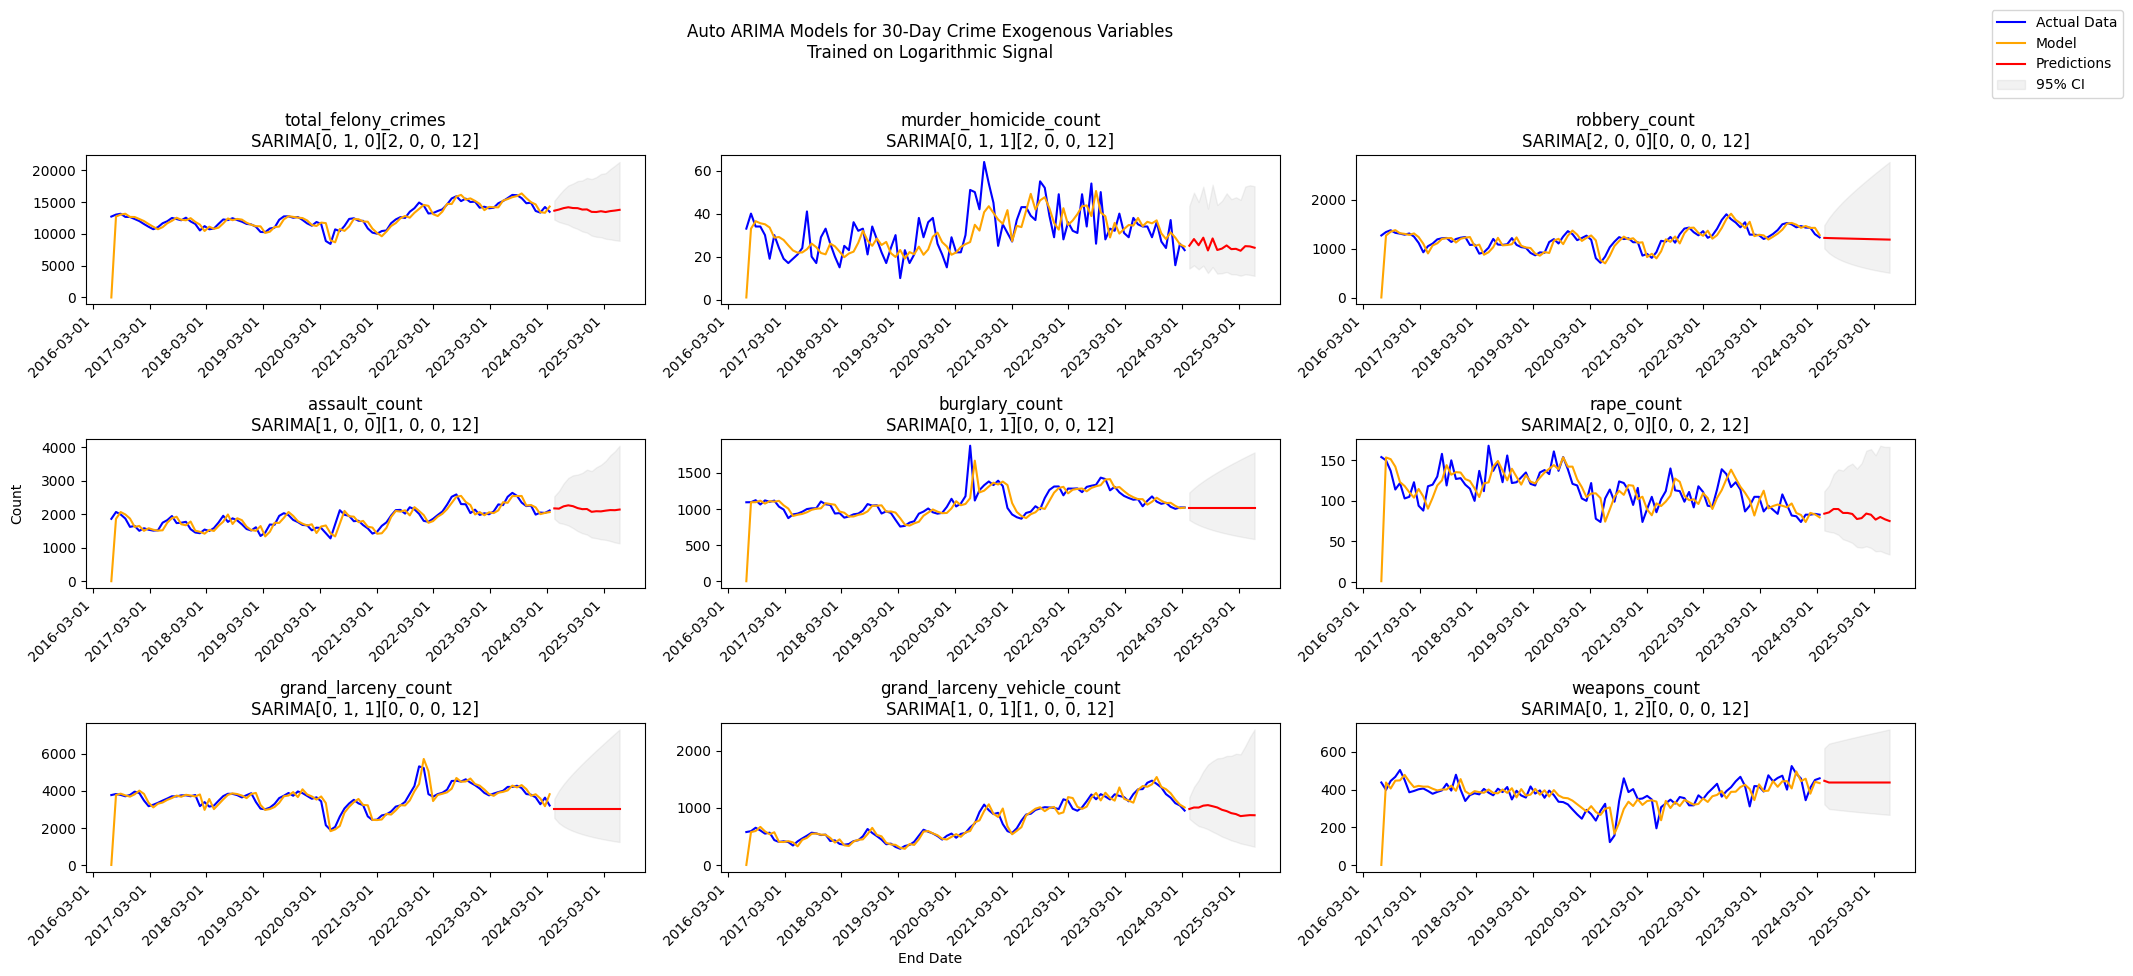

In [36]:
# Create the figure and subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 10), constrained_layout=True)
axes = axes.flatten()

#add column to the dataframe storing the exogenous variables that indicates actual data vs. predicted values
#force the time periods to be consistent across the exogenous variables datasets
exog_combined['Type'] = 'Actual Data'
# Generate future dates for forecast
last_date = crime_data['End Date'].iloc[-1]
future_dates = pd.date_range(start=last_date, periods=12+(len(_30day_pop_tot)-len(crime_data.dropna()))+1, freq='30D')[1:]


# Iterate over the dictionary and plot
for idx, var in enumerate(crime_data.columns.to_list()[2:]):
    print(f'Fitting the SARIMA model to {var}')
    # Prepare data
    y = crime_data[var].dropna()
    y_log = np.log(y)
    date = crime_data['End Date'].dropna()
    
    # Fit the ARIMA model for total felony crimes
    order = arima_dict[var]['order']
    seasonal_order = arima_dict[var]['seasonal_order']
    model = SARIMAX(y_log, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    #determine predictions lengths and save the output in dictionary
    n_steps = 12 + (len(_30day_pop_tot) - len(crime_data[var].dropna()))

    # Generate in-sample predictions
    y_pred_log = model_fit.fittedvalues
    y_pred = np.exp(y_pred_log)
    # Generate out-of-sample forecast_exog
    forecast = model_fit.get_forecast(steps=n_steps)
    y_forecast_log = forecast.predicted_mean
    y_forecast = np.exp(y_forecast_log)
    conf_int_log = forecast.conf_int()
    conf_int = np.exp(conf_int_log)
    # Plot the results
    ax = axes[idx]
    ax.plot(date, y, color=actual_color, label=legend_labels[0])
    ax.plot(date, y_pred, color=model_color, label=legend_labels[1])
    ax.plot(future_dates, y_forecast, color=forecast_color, label=legend_labels[2])
    ax.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color=ci_color, alpha=0.1, label=legend_labels[3])
    ax.set_title(f"{var}\nSARIMA{order}{seasonal_order}")
    # Set date formatting for x-axis
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Set common labels
fig.text(0.5, 0.04, 'End Date', ha='center')
fig.text(0.04, 0.5, 'Count', va='center', rotation='vertical')

# Create one legend for all subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, legend_labels, loc='upper right', bbox_to_anchor=(1.1, 1), bbox_transform=fig.transFigure)
fig.suptitle('Auto ARIMA Models for 30-Day Crime Exogenous Variables\nTrained on Logarithmic Signal')
plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.savefig('../Outputs/30_day_exog_auto_arima_plots_crime_counts_log.png', bbox_inches='tight')
plt.show()


c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


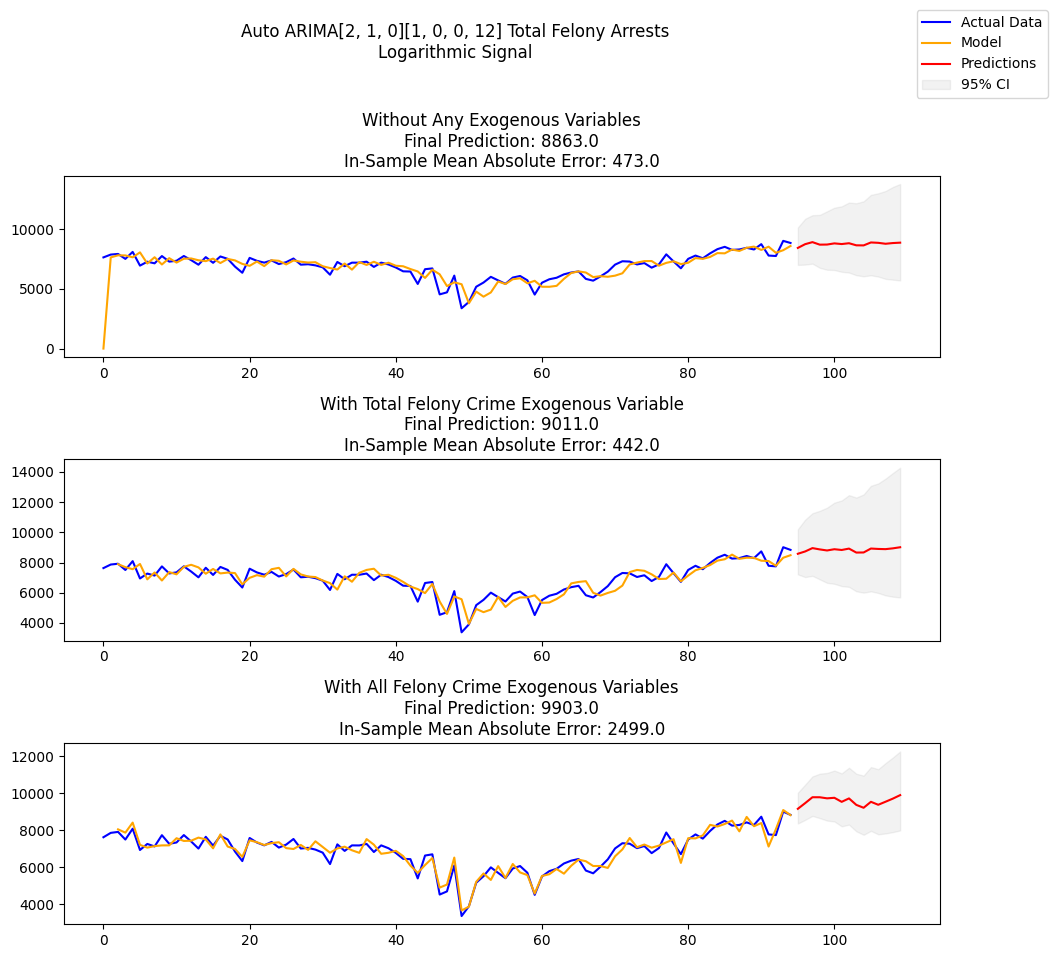

In [37]:
#now that we have the predicted values for the total felony crime
#we can use it to predict total felony arrests

#re-train the model
# Prepare data
y = exog_combined['total_felony_arrest'].dropna()
y_log = np.log(y)
var_ls = ['total_felony_crimes']
exog = exog_combined[var_ls].dropna()
exog_log = np.log(exog)
date = exog_combined['End Date'].dropna()

# Fit the ARIMA model
order = arima_dict['total_felony_arrest']['order']
seasonal_order = arima_dict['total_felony_arrest']['seasonal_order']
model1 = SARIMAX(y_log, order=order, seasonal_order=seasonal_order, exog = exog_log)
model1_fit = model1.fit(disp=False)

# Generate in-sample predictions
y_pred_exog_log = model1_fit.fittedvalues
y_pred_exog = np.exp(y_pred_exog_log)
# Generate out-of-sample forecast_exog
extra_n = (len(_30day_pop_tot) - len(crime_data.dropna()))
exog_pred = pd.concat([arima_dict['total_felony_crimes']['adjusted y'][-extra_n:],arima_dict['total_felony_crimes']['prediction']])
exog_pred_log = np.log(exog_pred)
forecast_exog = model1_fit.get_forecast(steps=n_steps, exog = exog_pred_log)
y_forecast_exog_log = forecast_exog.predicted_mean
y_forecast_exog = np.exp(y_forecast_exog_log)
conf_int_exog_log = forecast_exog.conf_int()
conf_int_exog = np.exp(conf_int_exog_log)
#in sample error
IS_mae_exog = mean_absolute_error(y, y_pred_exog)

#without exog
model_no_exog = SARIMAX(y_log, order=order, seasonal_order=seasonal_order)
model_fit_no_exog = model_no_exog.fit(disp=False)
# Generate in-sample predictions
y_pred_log = model_fit_no_exog.fittedvalues
y_pred = np.exp(y_pred_log)
forecast = model_fit_no_exog.get_forecast(steps=n_steps)
y_forecast_log = forecast.predicted_mean
y_forecast = np.exp(y_forecast_log)
conf_int_log = forecast.conf_int()
conf_int = np.exp(conf_int_log)#in sample error
IS_mae = mean_absolute_error(y, y_pred)


#use all exogenous felony crime variables
var_ls = crime_data.columns.to_list()[2:]
all_exog = exog_combined[var_ls].dropna()
all_exog_log = np.log(all_exog)
model = SARIMAX(y_log, order=order, seasonal_order=seasonal_order, exog = all_exog_log)
model_fit = model.fit(disp=False)

#quickly concat all the predictions for the exog parameter
all_exog_pred = pd.DataFrame(columns=all_exog.columns.to_list())
for var in var_ls:
    all_exog_pred[var] = pd.concat([arima_dict[var]['adjusted y'][-extra_n:],arima_dict[var]['prediction']]).values
all_exog_pred_log = np.log(all_exog_pred)
# Generate in-sample predictions
y_pred_all_exog_log = model_fit.fittedvalues
y_pred_all_exog = np.exp(y_pred_all_exog_log)
# Generate out-of-sample forecast_exog
forecast_all_exog = model_fit.get_forecast(steps=n_steps, exog = all_exog_pred_log)
y_forecast_all_exog_log = forecast_all_exog.predicted_mean
y_forecast_all_exog = np.exp(y_forecast_all_exog_log)
conf_int_all_exog_log = forecast_all_exog.conf_int()
conf_int_all_exog = np.exp(conf_int_all_exog_log)
#in sample error
IS_mae_all_exog = mean_absolute_error(y, y_pred_all_exog)
# Plot the results
fig, ax = plt.subplots(3,1,figsize = (10,10))
#without exog
ax[0].plot(y.index, y, color=actual_color, label=legend_labels[0])
ax[0].plot(y.index, y_pred, color=model_color, label=legend_labels[1])
ax[0].plot(np.arange(len(y),len(y)+n_steps), y_forecast, color=forecast_color, label=legend_labels[2]) 
ax[0].fill_between(np.arange(len(y),len(y)+n_steps), conf_int.iloc[:, 0], conf_int.iloc[:, 1], color=ci_color, alpha=0.1, label=legend_labels[3])
ax[0].set_title(f"Without Any Exogenous Variables\nFinal Prediction: {y_forecast.iloc[-1].round()}\nIn-Sample Mean Absolute Error: {IS_mae.round()}")
#with exog
ax[1].plot(y.index, y, color=actual_color, label=legend_labels[0])
ax[1].plot(y.iloc[2:].index, y_pred_exog.iloc[2:], color=model_color, label=legend_labels[1])
ax[1].plot(np.arange(len(y),len(y)+n_steps), y_forecast_exog, color=forecast_color, label=legend_labels[2]) 
ax[1].fill_between(np.arange(len(y),len(y)+n_steps), conf_int_exog.iloc[:, 0], conf_int_exog.iloc[:, 1], color=ci_color, alpha=0.1, label=legend_labels[3])
ax[1].set_title(f"With Total Felony Crime Exogenous Variable\nFinal Prediction: {y_forecast_exog.iloc[-1].round()}\nIn-Sample Mean Absolute Error: {IS_mae_exog.round()}")
#with all felony exog vars
ax[2].plot(y.index, y, color=actual_color, label=legend_labels[0])
ax[2].plot(y.iloc[2:].index, y_pred_all_exog.iloc[2:], color=model_color, label=legend_labels[1])
ax[2].plot(np.arange(len(y),len(y)+n_steps), y_forecast_all_exog, color=forecast_color, label=legend_labels[2]) 
ax[2].fill_between(np.arange(len(y),len(y)+n_steps), conf_int_all_exog.iloc[:, 0], conf_int_all_exog.iloc[:, 1], color=ci_color, alpha=0.1, label=legend_labels[3])
ax[2].set_title(f"With All Felony Crime Exogenous Variables\nFinal Prediction: {y_forecast_all_exog.iloc[-1].round()}\nIn-Sample Mean Absolute Error: {IS_mae_all_exog.round()}")

# Create one legend for all subplots
handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, legend_labels, loc='upper right', bbox_to_anchor=(1.1, 1), bbox_transform=fig.transFigure)
fig.suptitle(f"Auto ARIMA{order}{seasonal_order} Total Felony Arrests\nLogarithmic Signal")
plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.savefig("../Outputs/felony_arrest_SARIMAX_comparing_exog_outputs_02_log.png", bbox_inches = 'tight')
plt.show()

In [38]:
print(model_fit_no_exog.summary())

                                     SARIMAX Results                                      
Dep. Variable:                total_felony_arrest   No. Observations:                   95
Model:             SARIMAX(2, 1, 0)x(1, 0, 0, 12)   Log Likelihood                  88.133
Date:                            Fri, 21 Jun 2024   AIC                           -168.266
Time:                                    12:16:13   BIC                           -158.093
Sample:                                         0   HQIC                          -164.157
                                             - 95                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3783      0.078     -4.850      0.000      -0.531      -0.225
ar.L2         -0.4399      0.076   

In [39]:
print(model1_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                total_felony_arrest   No. Observations:                   95
Model:             SARIMAX(2, 1, 0)x(1, 0, 0, 12)   Log Likelihood                  94.228
Date:                            Fri, 21 Jun 2024   AIC                           -178.457
Time:                                    12:16:13   BIC                           -165.740
Sample:                                         0   HQIC                          -173.320
                                             - 95                                         
Covariance Type:                              opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
total_felony_crimes     0.6025      0.143      4.222      0.000       0.323       0.882
ar.L1   

In [40]:
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                total_felony_arrest   No. Observations:                   95
Model:             SARIMAX(2, 1, 0)x(1, 0, 0, 12)   Log Likelihood                 155.181
Date:                            Fri, 21 Jun 2024   AIC                           -284.362
Time:                                    12:16:13   BIC                           -251.299
Sample:                                         0   HQIC                          -271.007
                                             - 95                                         
Covariance Type:                              opg                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
total_felony_crimes             2.6197      0.387      6.772      0.000       1.

Since murder, rape, and robbery related crimes don't seem to be statistically significant, let's train one last model without these variables and compare the output to the outputs above.

In [41]:
sig_exog = all_exog.drop(columns=['murder_homicide_count','rape_count','robbery_count'])
sig_exog_pred = all_exog_pred.drop(columns=['murder_homicide_count','rape_count','weapons_count'])
sig_exog_log = np.log(sig_exog)
sig_exog_pred_log = np.log(sig_exog_pred)

model = SARIMAX(y_log, order=order, seasonal_order=seasonal_order, exog = sig_exog_log)
model_fit = model.fit(disp=False)

# Generate in-sample predictions
y_pred_sig_exog_log = model_fit.fittedvalues
y_pred_sig_exog = np.exp(y_pred_sig_exog_log)
# Generate out-of-sample forecast_exog
forecast_sig_exog = model_fit.get_forecast(steps=n_steps, exog = sig_exog_pred_log)
y_forecast_sig_exog_log = forecast_sig_exog.predicted_mean
y_forecast_sig_exog = np.exp(y_forecast_sig_exog_log)
#in sample error
IS_mae_sig_exog = mean_absolute_error(y, y_pred_sig_exog)
print(f'Final Prediction: {y_forecast_sig_exog.iloc[-1].round()}')
print(f'In-Sample Mean Absolute Error: {IS_mae_sig_exog.round()}')
print(model_fit.summary())

Final Prediction: 21917.0
In-Sample Mean Absolute Error: 1142.0
                                     SARIMAX Results                                      
Dep. Variable:                total_felony_arrest   No. Observations:                   95
Model:             SARIMAX(2, 1, 0)x(1, 0, 0, 12)   Log Likelihood                 153.504
Date:                            Fri, 21 Jun 2024   AIC                           -287.009
Time:                                    12:16:15   BIC                           -261.576
Sample:                                         0   HQIC                          -276.736
                                             - 95                                         
Covariance Type:                              opg                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
total_felony_cri

c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Based on the results from above, I think we should use the model trained only on the felony crime catch all variable. I believe this due to the fact that this variable is a function of all the other felony crime categories. Thus, including this variable in combination with the other variables could be impacting the performance of the model. Also, based on the final prediction results of the 4 models, this model is moderate.

In [42]:
#save the output of this model to the result dictionary
arima_dict['total_felony_arrest']['adjusted y'] = pd.concat([y,y_forecast_exog[0:n_steps-12]],ignore_index=True)
arima_dict['total_felony_arrest']['prediction'] = y_forecast_exog[n_steps-12:]
print(arima_dict['total_felony_arrest']['adjusted y'])
print(arima_dict['total_felony_arrest']['prediction'])

0     7630.000000
1     7866.000000
2     7918.000000
3     7505.000000
4     8091.000000
         ...     
93    9013.000000
94    8837.000000
95    8578.848151
96    8731.933956
97    8954.340619
Length: 98, dtype: float64
98     8867.738048
99     8798.050179
100    8880.054392
101    8829.968709
102    8921.843282
103    8658.901091
104    8665.176196
105    8925.359032
106    8898.520572
107    8885.596880
108    8938.093181
109    9011.288965
Name: predicted_mean, dtype: float64


Now that we have the predictions for total felony arrests. We can predict DOC admission counts. Recall that we have more data for DOC admissions than we do for the crime and arrest data. Thus, we will need to use some of the predicted data points from the total felony arrests as inputs into the model fitting (as opposed to the prediction step).

In [43]:
print(len(exog_combined['admission_count'].dropna()),len(exog_combined['total_felony_arrest'].dropna()))


97 95


In [44]:
print(len(exog_combined),len(_30day_pop_tot))

97 98


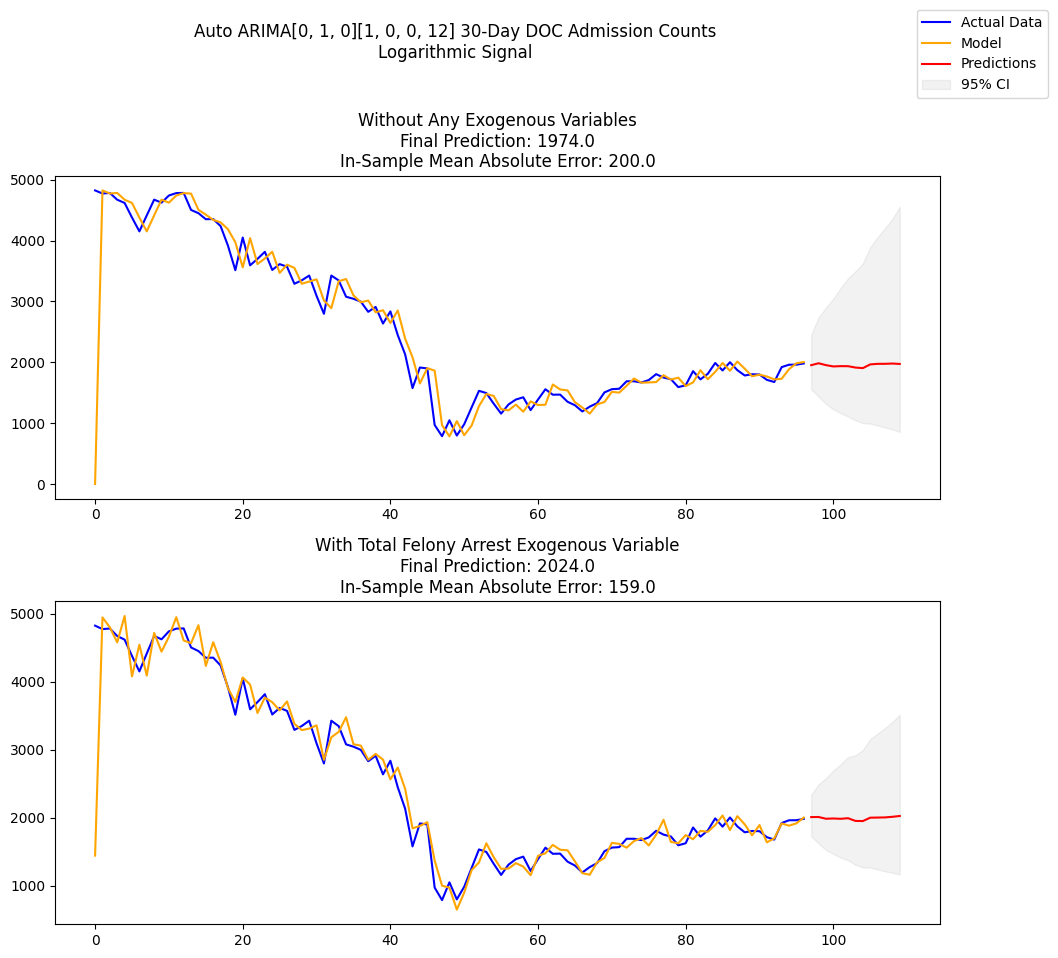

In [45]:
# Prepare data
y = exog_combined['admission_count'].dropna()
y_log = np.log(y)
#determine how many data points we are predicting
n_steps = 12 + (len(_30day_pop_tot) - len(exog_combined['admission_count'].dropna()))
extra_n = n_steps - 12
exog = arima_dict['total_felony_arrest']['adjusted y'][:-extra_n]
exog_log = np.log(exog)
exog_pred = pd.concat([arima_dict['total_felony_arrest']['adjusted y'][-extra_n:],arima_dict['total_felony_arrest']['prediction']])
exog_pred_log = np.log(exog_pred)

date = exog_combined['End Date'].dropna()

# Fit the ARIMA model
order = arima_dict['admission_count']['order']
seasonal_order = arima_dict['admission_count']['seasonal_order']
model = SARIMAX(y_log, order=order, seasonal_order=seasonal_order, exog = exog_log)
model_fit = model.fit(disp=False)

# Generate in-sample predictions
y_pred_exog_log = model_fit.fittedvalues
y_pred_exog = np.exp(y_pred_exog_log)
# Generate out-of-sample forecast_exog
forecast_exog = model_fit.get_forecast(steps=n_steps, exog = exog_pred_log)
y_forecast_exog_log = forecast_exog.predicted_mean
y_forecast_exog = np.exp(y_forecast_exog_log)
conf_int_exog_log = forecast_exog.conf_int()
conf_int_exog = np.exp(conf_int_exog_log)
#in sample error
IS_mae_exog = mean_absolute_error(y, y_pred_exog)

#without exog
model_no_exog = SARIMAX(y_log, order=order, seasonal_order=seasonal_order)
model_fit_no_exog = model_no_exog.fit(disp=False)
# Generate in-sample predictions
y_pred_log = model_fit_no_exog.fittedvalues
y_pred = np.exp(y_pred_log)
forecast = model_fit_no_exog.get_forecast(steps=n_steps)
y_forecast_log = forecast.predicted_mean
y_forecast = np.exp(y_forecast_log)
conf_int_log = forecast.conf_int()
conf_int = np.exp(conf_int_log)#in sample error
#in sample error
IS_mae = mean_absolute_error(y, y_pred)

# Plot the results
fig, ax = plt.subplots(2,1,figsize = (10,10))
#without exog
ax[0].plot(y.index, y, color=actual_color, label=legend_labels[0])
ax[0].plot(y.index, y_pred, color=model_color, label=legend_labels[1])
ax[0].plot(np.arange(len(y),len(y)+n_steps), y_forecast, color=forecast_color, label=legend_labels[2]) 
ax[0].fill_between(np.arange(len(y),len(y)+n_steps), conf_int.iloc[:, 0], conf_int.iloc[:, 1], color=ci_color, alpha=0.1, label=legend_labels[3])
ax[0].set_title(f"Without Any Exogenous Variables\nFinal Prediction: {y_forecast.iloc[-1].round()}\nIn-Sample Mean Absolute Error: {IS_mae.round()}")
#with exog
ax[1].plot(y.index, y, color=actual_color, label=legend_labels[0])
ax[1].plot(y.index, y_pred_exog, color=model_color, label=legend_labels[1])
ax[1].plot(np.arange(len(y),len(y)+n_steps), y_forecast_exog, color=forecast_color, label=legend_labels[2]) 
ax[1].fill_between(np.arange(len(y),len(y)+n_steps), conf_int_exog.iloc[:, 0], conf_int_exog.iloc[:, 1], color=ci_color, alpha=0.1, label=legend_labels[3])
ax[1].set_title(f"With Total Felony Arrest Exogenous Variable\nFinal Prediction: {y_forecast_exog.iloc[-1].round()}\nIn-Sample Mean Absolute Error: {IS_mae_exog.round()}")
# Create one legend for all subplots
handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, legend_labels, loc='upper right', bbox_to_anchor=(1.1, 1), bbox_transform=fig.transFigure)
fig.suptitle(f"Auto ARIMA{order}{seasonal_order} 30-Day DOC Admission Counts\nLogarithmic Signal")
plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.savefig("../Outputs/admission_count_SARIMAX_comparing_exog_outputs_02_log.png", bbox_inches = 'tight')
plt.show()

In [46]:
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    admission_count   No. Observations:                   97
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood                 109.127
Date:                            Fri, 21 Jun 2024   AIC                           -212.253
Time:                                    12:16:16   BIC                           -204.560
Sample:                                         0   HQIC                          -209.144
                                             - 97                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.8136      0.037     22.063      0.000       0.741       0.886
ar.S.L12       0.0911      0.105   

In [47]:
print(model_fit_no_exog.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    admission_count   No. Observations:                   97
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood                  70.110
Date:                            Fri, 21 Jun 2024   AIC                           -136.219
Time:                                    12:16:16   BIC                           -131.091
Sample:                                         0   HQIC                          -134.146
                                             - 97                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.2319      0.084      2.772      0.006       0.068       0.396
sigma2         0.0135      0.001   

In [48]:
#store the prediction from the exogenous model to the result dict
arima_dict['admission_count']['adjusted y'] = pd.concat([y,y_forecast_exog[0:n_steps-12]],ignore_index=True)
arima_dict['admission_count']['prediction'] = y_forecast_exog[n_steps-12:]
print(arima_dict['admission_count']['adjusted y'])
print(arima_dict['admission_count']['prediction'])

0     4825.000000
1     4774.000000
2     4783.000000
3     4672.000000
4     4619.000000
         ...     
93    1921.000000
94    1961.000000
95    1962.000000
96    1982.000000
97    2007.902979
Length: 98, dtype: float64
98     2009.348003
99     1983.594418
100    1987.517829
101    1982.881748
102    1991.477411
103    1951.392334
104    1949.577873
105    1999.363820
106    2001.144637
107    2003.271479
108    2012.115918
109    2024.131319
Name: predicted_mean, dtype: float64


In [51]:
def convert_series_to_list(d):
    for key, value in d.items():
        if isinstance(value, pd.Series):
            d[key] = value.tolist()
        elif isinstance(value, dict):
            convert_series_to_list(value)

In [52]:
convert_series_to_list(arima_dict)

#save latest updates to the result dict
with open("../Data/30_day_exog_ARIMA_models_log.json", 'w') as fp:
    json.dump(arima_dict, fp)

Continue to `03_model_training.ipynb` for next steps on fitting the final SARIMAX model for 30-day jail population. We will introduce some past policy interventions and major events, like COVID-19, and use the optimized SARIMAX model and predicted exogenous variables for DOC Admission Counts.  